In [1]:
import numpy as np
import pandas as pd
import nba_on_court as noc
import seaborn as sns
from sklearn.linear_model import RidgeCV
from nba_api.stats.endpoints import GameRotation, CommonPlayerInfo

pd.set_option('display.max_columns', 500)

This code uses data from a 3rd party source (see https://github.com/SCOREnetworkorg/sports-data-repository/blob/main/basketball/nba-rapm-data.qmd).

# Prepare the Data

First, load the data.

In [2]:
data: pd.DataFrame      = pd.read_csv('../../design_matrices/nba_2223_season_rapm_data.csv.gz', dtype={'game_id': str})
players: dict[int, str] = pd.read_csv('../../data/nba_2223_player_table.csv', index_col=0)['player_name'].to_dict()
games: pd.Series        = pd.unique(data['game_id'])

design  = data.drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)
data    = data[['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin']]
target  = data['margin']
weights = data['n_pos']

data

,game_id,stint_id,n_pos,home_points,away_points,minutes,margin
0,0022200002,1,14,5,2,2.70,21.428571
1,0022200002,2,9,6,2,1.67,44.444444
2,0022200002,3,5,0,3,0.48,-60.000000
3,0022200002,4,5,5,1,0.78,80.000000
4,0022200002,5,9,3,6,1.52,-33.333333
...,...,...,...,...,...,...,...
32379,0022201229,18,16,8,13,3.44,-31.250000
32380,0022201229,19,11,7,10,2.45,-27.272727
32381,0022201229,20,21,13,17,4.30,-19.047619
32382,0022201229,21,12,7,8,3.53,-8.333333


In [3]:
data['pm']   = data['home_points'] - data['away_points']

# Fit the Model

In [7]:
hypers = [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

model = RidgeCV( # Leave-One-Out CV based on MSE
    alphas=hypers,
    fit_intercept=False
).fit(design, target, sample_weight=weights)

In [8]:
results = pd.DataFrame({
    'Player ID': design.columns.astype(np.int32),
    'RAPM': model.coef_
})

results.insert(loc=1, column='Player Name', value=[
    players[player_id]
    for player_id in results['Player ID']
])

In [9]:
print(model.alpha_)

results.sort_values(by='RAPM', ascending=False).head(10)

5000


,Player ID,Player Name,RAPM
274,203999,Nikola Jokic,3.325439
2,203110,Draymond Green,3.308574
156,203954,Joel Embiid,3.211865
259,201950,Jrue Holiday,3.001383
306,202695,Kawhi Leonard,2.876934
260,203507,Giannis Antetokounmpo,2.772955
167,203076,Anthony Davis,2.696825
103,1631132,Christian Koloko,2.464661
273,203932,Aaron Gordon,2.450398
178,1628404,Josh Hart,2.319810


# Compute Average PM

Average PM is defined like so.

1. OnPM       = The Plus-Minus of the player while they were on the court.
2. OffPM      = The Plus-Minus while the player was off the court (in games where they were present at least once).
3. Average PM = (OnPM - OffPM) / Total Stints 

In [10]:
data

,game_id,stint_id,n_pos,home_points,away_points,minutes,margin,pm
0,0022200002,1,14,5,2,2.70,21.428571,3
1,0022200002,2,9,6,2,1.67,44.444444,4
2,0022200002,3,5,0,3,0.48,-60.000000,-3
3,0022200002,4,5,5,1,0.78,80.000000,4
4,0022200002,5,9,3,6,1.52,-33.333333,-3
...,...,...,...,...,...,...,...,...
32379,0022201229,18,16,8,13,3.44,-31.250000,-5
32380,0022201229,19,11,7,10,2.45,-27.272727,-3
32381,0022201229,20,21,13,17,4.30,-19.047619,-4
32382,0022201229,21,12,7,8,3.53,-8.333333,-1


In [11]:
results['Average Effect'] = np.empty(len(results))

# calculate average PM. 
onpm         = np.zeros(len(results))
offpm        = np.zeros(len(results))
total_stints = np.zeros(len(results))

for game_id in games:
    bools: list[bool]     = data['game_id'] == game_id
    game_data, indicators = data[bools], design[bools]

    sign           = np.sign(indicators.sum(axis=0))
    on_indicators  = indicators
    off_indicators = ((~on_indicators.astype(bool)).astype(int)).mul(sign, axis=1) # in case we need to swap -1, 0 instead of 1, 0

    onpm         += on_indicators.mul(game_data['pm'], axis=0).sum(axis=0).to_numpy()
    offpm        += off_indicators.mul(game_data['pm'], axis=0).sum(axis=0).to_numpy()
    total_stints += len(game_data) * np.abs(sign)

average_pm = (onpm - offpm) / total_stints

for plr_id, plr_avg_pm in zip(design.columns.astype(int), average_pm): # the order of the players in the columns matches the order in average_pm
    results.loc[results['Player ID'] == plr_id, 'Average Effect'] = plr_avg_pm

,Player ID,Player Name,RAPM,Average Effect
0,201939,Stephen Curry,1.016448,0.173258
1,202691,Klay Thompson,-0.179498,0.025368
2,203110,Draymond Green,3.308574,0.288675
3,203952,Andrew Wiggins,0.690161,0.176983
4,1626172,Kevon Looney,0.866554,0.071955
...,...,...,...,...
534,1628402,Frank Jackson,-0.020348,0.952381
535,1631495,Donovan Williams,0.142251,-0.243902
536,1630644,Mac McClung,0.345415,0.000000
537,1629663,Louis King,-0.016590,-0.964286


<Axes: xlabel='RAPM', ylabel='Average Effect'>

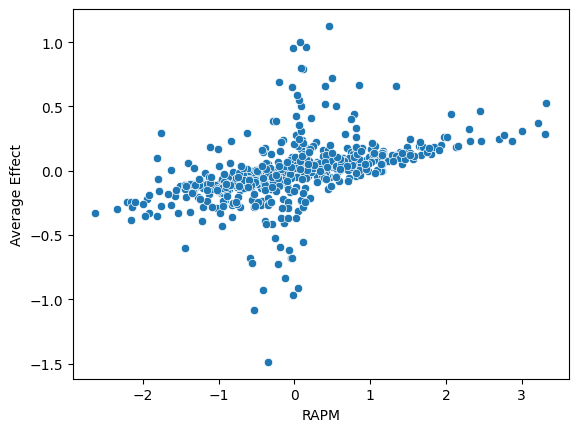

In [12]:
display(results)

sns.scatterplot(data=results, x='RAPM', y='Average Effect')

In [13]:
results.sort_values(by='RAPM', ascending=False).to_csv('../../results/ryurko_results.csv')

In [14]:
results['Average Effect'].corr(results['RAPM'])

0.47317244196482927

# Out-of-Sample Validation

Here we compute the RMSE of the RAPM model applied on the 2023-2024 season. Since the player roster's aren't exactly the same, it's necessary to filter out stints without new players.

In [15]:
from sklearn.metrics import root_mean_squared_error as rmse

oos_data: pd.DataFrame      = pd.read_csv('../../design_matrices/nba_2324_season_rapm_data.csv.gz', dtype={'game_id': str})
oos_players: dict[int, str] = pd.read_csv('../../data/nba_2324_player_table.csv', index_col='player_id')['player_name'].to_dict()
oos_design                  = oos_data.drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)
oos_data                    = oos_data[['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin']]


combined_plrs = np.intersect1d(list(oos_players), list(players))
missing_from_2324 = [
    str(x)
    for x in list(set(players) - set(combined_plrs))
]
missing_from_2223 = [
    str(x)
    for x in list(set(oos_players) - set(combined_plrs))
]

# filter out stints with new players
has_missing_player: pd.Series = oos_design[missing_from_2223].abs().sum(axis=1).astype(bool)

oos_design = oos_design[~has_missing_player].drop(missing_from_2223, axis=1)
oos_target = oos_data.loc[~has_missing_player, 'margin']

# add in players missing from 23/24 (they're just all zeros)
oos_design[missing_from_2324] = pd.DataFrame(
    data=np.zeros((len(oos_design.index), len(missing_from_2324)), dtype=np.int64),
    index=oos_design.index
)

# reorder the columns so the ordering matches the ordering of the 22/23 data
oos_design = oos_design[design.columns]

oos_design

,201939,202691,203110,203952,1626172,1629673,203210,1630164,1630228,1628978,1630541,1631157,201143,203935,1627759,1628369,1628401,203943,1629684,1627763,201933,1630573,203084,1627734,1628368,1628989,1629644,1628370,1629056,1630558,1626158,1626168,202711,1630180,1630191,1630595,1631093,1630165,1631105,1628995,202709,1628977,1627751,1629640,1630170,1630200,1631110,1630563,203926,1626196,1628380,1628966,203476,1629641,1629676,101108,1626164,1628969,1629028,1629661,1626166,1628470,1629111,203967,1627814,202687,1629006,203991,1627749,1628381,1629027,1629631,1630552,203200,1628988,1630168,201142,202681,1626220,1627732,1629651,201988,1630549,1628410,1630560,1629139,1630556,200768,202710,1628389,1628997,1629639,1629622,203473,1629216,1629130,1629312,1627783,1627832,1628384,1629018,1630567,1630173,1631132,1630625,201152,1627823,203500,1629630,1629723,1630217,1630583,1626145,1629634,1631223,1630214,1631222,201144,203482,203903,1628374,1629020,1629012,1631117,200752,1627736,1629659,1629638,1630195,1630534,1631323,1627741,1630169,1630188,1630537,1630678,1630543,1631097,204456,1629052,1630174,1629048,203497,1626156,1626157,1630162,1630183,203937,1629162,1629669,1627752,1627854,203085,200782,201935,202699,203954,1630178,1627777,1627863,1629001,1630194,1626149,1629680,2544,201566,201976,203076,1629022,1630559,1629308,1629134,1630346,1627745,1629675,203081,203924,203994,1628404,1629014,1626159,1629234,1631101,1629642,202330,203486,1626162,1626179,1629023,1630208,1629667,1628372,1630547,203925,202693,203078,204001,1628398,1628420,1630166,1629060,1626153,203115,1629655,1630264,203095,203944,1628973,1629011,1629628,1628392,1629629,1630167,1630193,201565,1630540,1630579,1627853,1629004,1631211,201569,1628981,1629645,1630224,1631095,1630231,1631106,1630578,1629726,1630528,1629614,201949,201580,203493,203915,1627827,1629029,203501,1626174,1628467,1630182,203939,1629033,1630702,1630593,1628416,1631099,1629002,203082,1628976,...,201609,203083,1627936,1627884,1628396,1631207,1630250,202331,202694,202704,1626181,1627826,201587,202322,1628379,203496,1629611,202695,1629599,1629650,1630527,1630554,1627747,1628378,1628386,1630171,1630596,1626224,201567,1629731,201577,203526,1628972,1631100,1630235,1630249,1631213,1629026,1629652,1630526,1630544,1630581,1630197,1630598,1629647,1630647,1631119,1631172,1630322,203488,1630198,1630792,1630233,1630553,1630535,1631133,1629003,1627788,1630531,1626246,1630227,1630586,1628415,1629013,1628983,201959,1631098,1630225,1630692,202685,203468,1630230,1630530,1630631,1626204,1628984,1630700,1629637,1630587,201599,1628432,202397,1628427,1631212,1631298,1628449,203920,1629660,1631320,203458,203521,1630561,203585,1628436,1631104,1630201,1630551,1631216,1629678,1630176,1630648,1630613,203552,1630177,1630550,1631217,1629117,1630202,1628382,1629603,1630205,1631103,1628962,1630695,1630288,1631199,1631114,1631160,1629646,1631230,1629656,1629636,1630591,1626167,1630557,1631113,1631246,1627742,1629627,1630529,1631108,203457,203490,1630237,1626163,1629633,1631120,1631107,1631288,1628963,202692,1631102,1630570,1630688,1626195,1630163,1630267,1628373,202722,1631165,1628991,203471,1628418,1630600,1626192,202066,1630577,1630701,1631112,1630539,1631116,203914,1629021,1630696,1631254,1631111,1629662,1629653,1628365,203992,1628993,1631121,203933,203114,203506,1630568,1630533,1626169,1629057,202689,1631169,1629674,1631115,1630184,1631109,1630639,204060,1627780,1628998,1630256,1628425,1630590,1631306,2738,1628408,1630243,201937,1630240,1630580,1631219,1628371,201980,1628464,1630620,1631123,1631245,1630637,1627739,203109,203086,1630548,203469,1630215,1630241,1630846,1631197,1630209,1631205,1630643,1629623,1629685,1641645,1629714,1629875,1631311,1630270,1628424,1630219,1627885,1630206,203487,1629677,1628221,1631466,1628435,1631303,2617,1630564,1630296,1631309,1631220,1631214,1629126,1629735,1630649,1628402,1631495,1630644,1629663,1631367
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
rmse(oos_target, model.predict(oos_design))

69.42993450384262